In [31]:
import torch
import numpy as np
import os
from itertools import combinations
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from torch.nn.utils import clip_grad_norm_

# =====================================================
# 1. Dataset Classes (with NaN filtering)
# =====================================================

class BaseAntibodyDataset(Dataset):
    def __init__(self, embed_file, desc_file, labels_file=None, which=[0], fold=slice(None)):
        # Load embeddings & descriptors
        self.features = np.load(embed_file)[fold]
        self.desc = np.load(desc_file)[fold]

        # Load selected label columns
        if labels_file:
            self.labels = np.load(labels_file)[fold][:, which]
        else:
            self.labels = np.ones(len(self.desc))
        if self.labels.ndim == 1:
            self.labels = self.labels[:, None]

        # --- Filter out samples with ANY NaNs across the selected targets ---
        valid_mask = ~np.isnan(self.labels).any(axis=1)
        self.features = self.features[valid_mask]
        self.desc = self.desc[valid_mask]
        self.labels = self.labels[valid_mask]

        print(f"Loaded {len(self.features)} valid samples (filtered NaNs across {len(which)} targets)")

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return (
            torch.tensor(self.features[idx], dtype=torch.float),
            torch.tensor(self.desc[idx], dtype=torch.float),
            torch.tensor(self.labels[idx], dtype=torch.float),
        )


class WarmupDataset(Dataset):
    """
    Warmup dataset:
    - Uses AbLang embeddings (NxD)
    - Uses zero descriptors of same shape as desc_file
    - Supports multitask labels via 'which'
    - Filters out samples with NaNs in *any* selected label column
    """
    def __init__(self, embed_file, desc_file, labels_file, which=[0], fold=slice(None)):
        # 1. Load embeddings
        self.features = np.load(embed_file)[fold]

        # 2. Create zero descriptors same shape as template
        desc_template = np.load(desc_file)
        self.desc = np.zeros_like(desc_template)[fold]

        # 3. Load label columns
        self.labels = np.load(labels_file)[fold][:, which]
        if self.labels.ndim == 1:
            self.labels = self.labels[:, None]

        # 4. Filter out any sample with NaN in any selected column
        valid_mask = ~np.isnan(self.labels).any(axis=1)
        self.features = self.features[valid_mask]
        self.desc = self.desc[valid_mask]
        self.labels = self.labels[valid_mask]

        print(f"Loaded {len(self.features)} warmup samples (filtered NaNs across {len(which)} targets)")

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return (
            torch.tensor(self.features[idx], dtype=torch.float),
            torch.tensor(self.desc[idx], dtype=torch.float),
            torch.tensor(self.labels[idx], dtype=torch.float),
        )


def collate_batch(batch):
    embeds, descs, labels = zip(*batch)
    embeds = torch.stack(embeds)
    descs = torch.stack(descs)
    labels = torch.stack(labels)
    return embeds, descs, labels


class AntibodyModel1(nn.Module):
    def __init__(self, embed_dim=480, hidden_dim=256, dsp_dim=30, output_dim=1):
        super().__init__()

        # store dims for easy replace_head
        self._embed_dim = embed_dim
        self._dsp_dim = dsp_dim
        self._hidden_dim = hidden_dim
        self._fusion_dim = hidden_dim // 4 +  dsp_dim // 2 # after concatenation e+d -> hidden_dim

        # Embedding branch -> outputs hidden_dim//2
        self.ablang_branch = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.LayerNorm(hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, hidden_dim // 4),
            nn.LayerNorm(hidden_dim // 4),
            nn.ReLU(),
        )

        # Descriptor branch -> outputs hidden_dim//2
        self.desc_branch = nn.Sequential(
            nn.Linear(dsp_dim, dsp_dim // 2),
            nn.LayerNorm(dsp_dim // 2),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(dsp_dim // 2, dsp_dim // 2),
            nn.LayerNorm(dsp_dim // 2),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        # Fusion trunk is simply concatenation into fusion_dim (hidden_dim)
        # and a small trunk could be added here if desired; for simplicity we
        # keep the trunk minimal and place final layers into self.out
        # Final prediction head (easy to replace)
        self.out = nn.Sequential(
            nn.Linear(self._fusion_dim, self._fusion_dim // 2),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(self._fusion_dim // 2, output_dim),
        )

        # initialize weights for all linear modules
        self._init_weights()

    def forward(self, embeds, descs):
        e = self.ablang_branch(embeds)           # (B, hidden_dim//2)
        d = self.desc_branch(descs)              # (B, hidden_dim//2)
        x = torch.cat([e, d], dim=-1)            # (B, hidden_dim)
        return self.out(x)                       # (B, output_dim)

    def replace_head(self, output_dim=1):
        """Replace only the final prediction head (self.out) and reinitialize it."""
        # create a fresh self.out with same input fusion dim
        self.out = nn.Sequential(
            nn.Linear(self._fusion_dim, self._fusion_dim // 2),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(self._fusion_dim // 2, output_dim),
        )
        # initialize new head weights
        for m in self.out.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, nonlinearity="relu")
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, nonlinearity="relu")
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
    def freeze_ablang(self, freeze=True):
        for p in self.ablang_branch.parameters():
            p.requires_grad = not freeze

class AntibodyModel2(nn.Module):
    def __init__(self, embed_dim=480, hidden_dim=256, dsp_dim=30, output_dim=1):
        super().__init__()

        # store dims for easy replace_head
        self._embed_dim = embed_dim
        self._dsp_dim = dsp_dim
        self._hidden_dim = hidden_dim
        self._fusion_dim = hidden_dim // 4 + dsp_dim // 4  # after concatenation e+d -> hidden_dim

        # Embedding branch -> outputs hidden_dim//4
        self.ablang_branch = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.GELU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.LayerNorm(hidden_dim // 2),
            nn.GELU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim // 2, hidden_dim // 4),
            nn.LayerNorm(hidden_dim // 4),
            nn.GELU(),
        )

        # Descriptor branch -> outputs dsp_dim//4
        self.desc_branch = nn.Sequential(
            nn.Linear(dsp_dim, dsp_dim // 2),
            nn.LayerNorm(dsp_dim // 2),
            nn.GELU(),
            nn.Dropout(0.3),
            nn.Linear(dsp_dim // 2, dsp_dim // 4),
            nn.LayerNorm(dsp_dim // 4),
            nn.GELU(),
        )

        # Fusion trunk is simply concatenation into fusion_dim (hidden_dim)
        # and a small trunk could be added here if desired; for simplicity we
        # keep the trunk minimal and place final layers into self.out
        # Final prediction head (easy to replace)
        self.out = nn.Sequential(
            nn.Linear(self._fusion_dim, self._fusion_dim // 2),
            nn.GELU(),
            nn.Dropout(0.4),
            nn.Linear(self._fusion_dim // 2, self._fusion_dim // 4),
            nn.GELU(),
            nn.Dropout(0.4),
            nn.Linear(self._fusion_dim // 4, self._fusion_dim // 6),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(self._fusion_dim // 6, output_dim),
        )

        # initialize weights for all linear modules
        self._init_weights()

    def forward(self, embeds, descs):
        e = self.ablang_branch(embeds)           # (B, hidden_dim//2)
        d = self.desc_branch(descs)              # (B, hidden_dim//2)
        x = torch.cat([e, d], dim=-1)            # (B, hidden_dim)
        return self.out(x)                       # (B, output_dim)

    def replace_head(self, output_dim=1):
        """Replace only the final prediction head (self.out) and reinitialize it."""
        # create a fresh self.out with same input fusion dim
        self.out = nn.Sequential(
            nn.Linear(self._fusion_dim, self._fusion_dim // 2),
            nn.GELU(),
            nn.Dropout(0.4),
            nn.Linear(self._fusion_dim // 2, self._fusion_dim // 4),
            nn.GELU(),
            nn.Dropout(0.4),
            nn.Linear(self._fusion_dim // 4, self._fusion_dim // 6),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(self._fusion_dim // 6, output_dim),
        )
        # initialize new head weights
        for m in self.out.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, nonlinearity="relu")
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, nonlinearity="relu")
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
                    
    def freeze_ablang(self, freeze=True):
        for p in self.ablang_branch.parameters():
            p.requires_grad = not freeze
    def freeze_dsp(self, freeze=True):
        for p in self.desc_branch.parameters():
            p.requires_grad = not freeze

class AntibodyModel3(nn.Module):
    def __init__(self, embed_dim=480, hidden_dim=256, dsp_dim=30, output_dim=1):
        super().__init__()

        # store dims for easy replace_head
        self._embed_dim = embed_dim
        self._dsp_dim = dsp_dim
        self._hidden_dim = hidden_dim
        self._fusion_dim = hidden_dim // 4 + dsp_dim // 4  # after concatenation e+d -> hidden_dim

        # Embedding branch -> outputs hidden_dim//4
        self.ablang_branch = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.GELU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.LayerNorm(hidden_dim // 2),
            nn.GELU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim // 2, hidden_dim // 4),
            nn.LayerNorm(hidden_dim // 4),
            nn.GELU(),
        )

        # Descriptor branch -> outputs dsp_dim//4
        self.desc_branch = nn.Sequential(
            nn.Linear(dsp_dim, dsp_dim // 2),
            nn.LayerNorm(dsp_dim // 2),
            nn.GELU(),
            nn.Dropout(0.3),
            nn.Linear(dsp_dim // 2, dsp_dim // 4),
            nn.LayerNorm(dsp_dim // 4),
            nn.GELU(),
        )

        # Fusion trunk is simply concatenation into fusion_dim (hidden_dim)
        # and a small trunk could be added here if desired; for simplicity we
        # keep the trunk minimal and place final layers into self.out
        # Final prediction head (easy to replace)
        self.con = nn.Sequential(
            nn.Linear(self._fusion_dim, self._fusion_dim),
            nn.GELU()
        )
        
        self.out = nn.Sequential(
            nn.Linear(self._fusion_dim, self._fusion_dim // 2),
            nn.GELU(),
            nn.Dropout(0.4),
            nn.Linear(self._fusion_dim // 2, self._fusion_dim // 4),
            nn.GELU(),
            nn.Dropout(0.4),
            nn.Linear(self._fusion_dim // 4, self._fusion_dim // 6),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(self._fusion_dim // 6, output_dim)
        )

        # initialize weights for all linear modules
        self._init_weights()

    def forward(self, embeds, descs):
        e = self.ablang_branch(embeds)           # (B, hidden_dim//2)
        d = self.desc_branch(descs)              # (B, hidden_dim//2)
        x = torch.cat([e, d], dim=-1)            # (B, hidden_dim)
        x = self.con(x)
        return self.out(x)                       # (B, output_dim)

    def replace_head(self, output_dim=1):
        """Replace only the final prediction head (self.out) and reinitialize it."""
        # create a fresh self.out with same input fusion dim
        self.out = nn.Sequential(
            nn.Linear(self._fusion_dim, self._fusion_dim // 2),
            nn.GELU(),
            nn.Dropout(0.4),
            nn.Linear(self._fusion_dim // 2, self._fusion_dim // 4),
            nn.GELU(),
            nn.Dropout(0.4),
            nn.Linear(self._fusion_dim // 4, self._fusion_dim // 6),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(self._fusion_dim // 6, output_dim)
        )
        # initialize new head weights
        for m in self.out.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, nonlinearity="relu")
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, nonlinearity="relu")
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
                    
    def freeze_ablang(self, freeze=True):
        for p in self.ablang_branch.parameters():
            p.requires_grad = not freeze
    def freeze_dsp(self, freeze=True):
        for p in self.desc_branch.parameters():
            p.requires_grad = not freeze

class AntibodyModel4(nn.Module):
    def __init__(self, embed_dim=480, hidden_dim=256, dsp_dim=30, output_dim=1):
        super().__init__()

        # store dims for easy replace_head
        self._embed_dim = embed_dim
        self._dsp_dim = dsp_dim
        self._hidden_dim = hidden_dim
        self._fusion_dim = hidden_dim // 4 + dsp_dim // 4  # after concatenation e+d -> hidden_dim

        # Embedding branch -> outputs hidden_dim//4
        self.ablang_branch = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.GELU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.LayerNorm(hidden_dim // 2),
            nn.GELU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim // 2, hidden_dim // 4),
            nn.LayerNorm(hidden_dim // 4),
            nn.GELU()
        )

        # Descriptor branch -> outputs dsp_dim//4
        self.desc_branch = nn.Sequential(
            nn.Linear(dsp_dim, dsp_dim // 2),
            nn.LayerNorm(dsp_dim // 2),
            nn.GELU(),
            nn.Dropout(0.3),
            nn.Linear(dsp_dim // 2, dsp_dim // 4),
            nn.LayerNorm(dsp_dim // 4),
            nn.GELU()
        )

        # Fusion trunk is simply concatenation into fusion_dim (hidden_dim)
        # and a small trunk could be added here if desired; for simplicity we
        # keep the trunk minimal and place final layers into self.out
        # Final prediction head (easy to replace)
        self.con = nn.Sequential(
            nn.Linear(self._fusion_dim, self._fusion_dim),
            nn.GELU()
        )
        
        self.out = nn.Sequential(
            nn.Linear(self._fusion_dim, self._fusion_dim // 2),
            nn.GELU(),
            nn.Dropout(0.4),
            nn.Linear(self._fusion_dim // 2, self._fusion_dim // 4),
            nn.GELU(),
            nn.Dropout(0.4),
            nn.Linear(self._fusion_dim // 4, self._fusion_dim // 6),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(self._fusion_dim // 6, output_dim)
        )

        # initialize weights for all linear modules
        self._init_weights()

    def forward(self, embeds, descs):
        e = self.ablang_branch(embeds)           # (B, hidden_dim//2)
        d = self.desc_branch(descs)              # (B, hidden_dim//2)
        x = torch.cat([e, d], dim=-1)            # (B, hidden_dim)
        x = self.con(x)
        return self.out(x)                       # (B, output_dim)

    def replace_head(self, output_dim=1):
        """Replace only the final prediction head (self.out) and reinitialize it."""
        # create a fresh self.out with same input fusion dim
        self.out = nn.Sequential(
            nn.Linear(self._fusion_dim, self._fusion_dim // 2),
            nn.GELU(),
            nn.Dropout(0.4),
            nn.Linear(self._fusion_dim // 2, self._fusion_dim // 4),
            nn.GELU(),
            nn.Dropout(0.4),
            nn.Linear(self._fusion_dim // 4, self._fusion_dim // 6),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(self._fusion_dim // 6, output_dim)
        )
        # initialize new head weights
        for m in self.out.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, nonlinearity="relu")
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, nonlinearity="relu")
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
                    
    def freeze_ablang(self, freeze=True):
        for p in self.ablang_branch.parameters():
            p.requires_grad = not freeze
    def freeze_dsp(self, freeze=True):
        for p in self.desc_branch.parameters():
            p.requires_grad = not freeze


class AntibodyModel5(nn.Module):
    def __init__(self, embed_dim=480, hidden_dim=256, dsp_dim=30, output_dim=1):
        super().__init__()

        # store dims for easy replace_head
        self._embed_dim = embed_dim
        self._dsp_dim = dsp_dim
        self._hidden_dim = hidden_dim
        self._fusion_dim = hidden_dim // 4 +  dsp_dim // 2 # after concatenation e+d -> hidden_dim

        # Embedding branch -> outputs hidden_dim//2
        self.ablang_branch = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.GELU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.LayerNorm(hidden_dim // 2),
            nn.GELU(),
            nn.Linear(hidden_dim // 2, hidden_dim // 4),
            nn.LayerNorm(hidden_dim // 4),
            nn.GELU(),
        )

        # Descriptor branch -> outputs hidden_dim//2
        self.desc_branch = nn.Sequential(
            nn.Linear(dsp_dim, dsp_dim // 2),
            nn.LayerNorm(dsp_dim // 2),
            nn.GELU(),
            nn.Dropout(0.3),
            nn.Linear(dsp_dim // 2, dsp_dim // 2),
            nn.LayerNorm(dsp_dim // 2),
            nn.GELU(),
            nn.Dropout(0.3)
        )

        # Fusion trunk is simply concatenation into fusion_dim (hidden_dim)
        # and a small trunk could be added here if desired; for simplicity we
        # keep the trunk minimal and place final layers into self.out
        # Final prediction head (easy to replace)
        self.out = nn.Sequential(
            nn.Linear(self._fusion_dim, self._fusion_dim // 2),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(self._fusion_dim // 2, output_dim),
        )

        # initialize weights for all linear modules
        self._init_weights()

    def forward(self, embeds, descs):
        e = self.ablang_branch(embeds)           # (B, hidden_dim//2)
        d = self.desc_branch(descs)              # (B, hidden_dim//2)
        x = torch.cat([e, d], dim=-1)            # (B, hidden_dim)
        return self.out(x)                       # (B, output_dim)

    def replace_head(self, output_dim=1):
        """Replace only the final prediction head (self.out) and reinitialize it."""
        # create a fresh self.out with same input fusion dim
        self.out = nn.Sequential(
            nn.Linear(self._fusion_dim, self._fusion_dim // 2),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(self._fusion_dim // 2, output_dim),
        )
        # initialize new head weights
        for m in self.out.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, nonlinearity="relu")
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, nonlinearity="relu")
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
                    
    def freeze_ablang(self, freeze=True):
        for p in self.ablang_branch.parameters():
            p.requires_grad = not freeze
    def freeze_dsp(self, freeze=True):
        for p in self.desc_branch.parameters():
            p.requires_grad = not freeze


# -----------------------------
# Train & Evaluate
# -----------------------------
def train_one_epoch(model, loader, optimizer, device, grad_clip=1):
    model.train()
    criterion = nn.MSELoss()
    running_loss = 0.0
    for embeds, descs, labels in loader:
        embeds, descs, labels = embeds.to(device), descs.to(device), labels.to(device)
        optimizer.zero_grad()
        preds = model(embeds, descs).squeeze(-1)
        loss = criterion(preds, labels.squeeze(-1))
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        optimizer.step()
        running_loss += loss.item() * embeds.size(0)
    return running_loss / len(loader.dataset)

def evaluate(model, loader, device):
    """
    Evaluate model performance on a DataLoader, computing per-target RÂ².
    Returns:
        avg_loss: float, mean loss over dataset
        r2_mean: float, mean RÂ² across all targets
        r2_per_target: list of floats, RÂ² per target
    """
    model.eval()
    total_loss = 0.0
    total_samples = 0
    preds_list, labels_list = [], []

    criterion = nn.MSELoss(reduction='sum')  # sum for averaging later

    with torch.no_grad():
        for embeds, descs, labels in loader:
            embeds = embeds.to(device)
            descs = descs.to(device)
            labels = labels.to(device)

            outputs = model(embeds, descs)  # shape: (B, num_targets)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            total_samples += embeds.size(0)

            preds_list.append(outputs.cpu())
            labels_list.append(labels.cpu())

    if total_samples == 0:
        return float("nan"), float("nan"), []

    preds_all = torch.cat(preds_list, dim=0)  # (N, num_targets)
    labels_all = torch.cat(labels_list, dim=0)

    # Compute per-target RÂ²
    r2_per_target = []
    for i in range(labels_all.shape[1]):
        ss_res = torch.sum((labels_all[:, i] - preds_all[:, i]) ** 2)
        ss_tot = torch.sum((labels_all[:, i] - labels_all[:, i].mean()) ** 2)
        r2 = 1 - ss_res / ss_tot
        r2_per_target.append(r2.item())

    r2_mean = np.mean(r2_per_target)
    avg_loss = total_loss / total_samples

    return avg_loss, r2_mean, r2_per_target

def warmup_train(dataset, model_class, epochs=50, batch_size=16, lr=1e-4,
                 weight_decay=1e-5, device='cuda', save_path='warmup.pt', patience=5, con=False, output_dim=1):
    """
    Pretrain the model on a large auxiliary dataset (e.g., TAP dataset)
    with early stopping based on validation loss.
    """

    # Split for validation
    val_size = int(0.1 * len(dataset))
    train_size = len(dataset) - val_size
    train_ds, val_ds = random_split(dataset, [train_size, val_size])
    
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

    model = model_class().to(device)
    model.freeze_ablang(False)  # train all during warmup

    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    best_val = np.inf
    best_epoch = 0
    patience_counter = 0
    if con and os.path.exists(save_path):
        state_dict = torch.load(save_path, map_location=device)
        model.load_state_dict(state_dict, strict=False)
        model.replace_head(output_dim=output_dim)

    print(f"?? Starting warmup: {len(train_ds)} train, {len(val_ds)} val samples")

    for epoch in range(epochs):
        train_loss = train_one_epoch(model, train_loader, optimizer, device)
        val_loss, r2_mean, r2_per_target = evaluate(model, val_loader, device)

        print(f"Warmup Epoch {epoch+1}] "
              f"Train={train_loss:.4f}, Val={val_loss:.4f}, "
              f"R2_mean={r2_mean:.3f}, R2_per_target={r2_per_target}")
        # Check for improvement
        if val_loss < best_val - 1e-6:  # small threshold to avoid noise
            best_val = val_loss
            best_epoch = epoch
            patience_counter = 0
            torch.save(model.state_dict(), save_path)
        else:
            patience_counter += 1

        # Early stopping
        if patience_counter >= patience:
            print(f"? Early stopping triggered at epoch {epoch+1} "
                  f"(best epoch {best_epoch+1}, val_loss={best_val:.4f})")
            break

    print(f"? Warmup finished. Best model (epoch {best_epoch+1}) saved to {save_path}")
    return model


def cross_validate_with_pretrained(dataset, model_class, pretrained_path=None,
                                   fa="fold_array.npy", epochs=500, batch_size=8,
                                   device="cuda", lr=1e-4, weight_decay=1e-3,
                                   patience=50, frz_a=20, frz_d=20, output_dim=5, save=False, save_name=1):

    fold_array = np.load(fa)
    if len(fold_array) != len(dataset):
        fold_array = fold_array[:len(dataset)]

    k = int(fold_array.max()) + 1
    val_losses, val_r2s = [], []

    for fold in range(k):
        val_idx = np.where(fold_array == fold)[0]
        train_idx = np.where(fold_array != fold)[0]

        train_subset = Subset(dataset, train_idx)
        val_subset = Subset(dataset, val_idx)
        train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, collate_fn=collate_batch)
        val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, collate_fn=collate_batch)

        model = model_class().to(device)
        if pretrained_path:
            state_dict = torch.load(pretrained_path, map_location=device)
            model.load_state_dict(state_dict, strict=False)
            model.replace_head(output_dim=output_dim)

        optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()),
                                      lr=lr, weight_decay=weight_decay)

        best_val = float("inf")
        best_r2 = -float("inf")
        wait = 0
        best_state = None
        unfrozen_a = False
        unfrozen_d = False
        model.freeze_ablang(True)

        for epoch in range(epochs):
            train_loss = train_one_epoch(model, train_loader, optimizer, device)
            val_loss, r2_mean, r2_targets = evaluate(model, val_loader, device)
            print(f"[Fold {fold+1} | Epoch {epoch+1}] Train={train_loss:.4f}, Val={val_loss:.4f}, R2={r2_mean:.3f}")

            if val_loss < best_val:
                best_val = val_loss
                best_r2 = r2_mean
                best_state = model.state_dict()
                wait = 0
            else:
                wait += 1

            if wait >= patience:
                print(f"Early stopping at epoch {epoch+1} (fold {fold+1})")
                break
                
            if wait >= frz_a and not unfrozen_a:
                model.freeze_ablang(False)
                unfrozen_a = True
                
            if wait >= frz_d and not unfrozen_d:
                model.freeze_dsp(False)
                unfrozen_d = True

        if best_state and save:
            torch.save(best_state, f"cv_fold_{save_name}_{fold}.pt")
        val_losses.append(best_val)
        val_r2s.append(best_r2)

    print("CV results:", val_losses)
    print("Mean loss:", np.mean(val_losses))
    print("Mean R2:", np.mean(val_r2s))

    return val_losses, val_r2s


def objective(trial, finetune_task, model_class):
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # --- Warmup choice (use stringified combos to avoid Optuna warning) ---
    choice = trial.suggest_categorical('warmup_tasks', warmup_choices)
    warmup_tasks = list(map(int, choice.split(',')))
    n_warmup = len(warmup_tasks)

    # --- Hyperparameters ---
    warmup_lr = trial.suggest_loguniform("warmup_lr", 1e-6, 1e-3)
    warmup_wd = trial.suggest_loguniform("warmup_wd", 1e-6, 1e-3)
    warmup_epochs = trial.suggest_int("warmup_epochs", 10, 60)

    finetune_lr = trial.suggest_loguniform("finetune_lr", 1e-6, 1e-3)
    finetune_wd = trial.suggest_loguniform("finetune_wd", 1e-6, 1e-3)
    patience = trial.suggest_int("patience", 20, 60)
    frz_a = trial.suggest_int("freeze_epochsa", 10, 40)
    frz_d = trial.suggest_int("freeze_epochsb", 10, 40)

    # Unique warmup checkpoint filename per process/trial to avoid collisions
    warmup_ckpt = f"warmup_trial_{finetune_task}_{model_class.__name__}_{os.getpid()}_{uuid.uuid4().hex}.pt"

    # --- Warmup Stage ---
    warmup_data = WarmupDataset(
        "thera_11_embeddings2.npy",
        "thera_11_DSP.npy",
        "thera_TAP.npy",
        which=warmup_tasks
    )
    warmup_train(
        warmup_data,
        model_class=lambda: model_class(output_dim=n_warmup),
        epochs=warmup_epochs,
        batch_size=128,
        lr=warmup_lr,
        weight_decay=warmup_wd,
        device=device,
        save_path=warmup_ckpt,
        patience=10
    )

    # --- Finetune Stage ---
    dataset = BaseAntibodyDataset(
        "train_embeddings2.npy",
        "train_DSP_out.npy",
        "all_data.npy",
        which=[finetune_task]  # always single-task finetune here
    )

    val_losses, r2_scores = cross_validate_with_pretrained(
        dataset=dataset,
        model_class=lambda: model_class(output_dim=n_warmup),
        pretrained_path=warmup_ckpt,
        fa="fold_array.npy",
        epochs=200,
        batch_size=32,
        device=device,
        lr=finetune_lr,
        weight_decay=finetune_wd,
        patience=patience,
        frz_a=frz_a,
        frz_d=frz_d,
        output_dim=1,
        save=False
    )

    # Cleanup
    if os.path.exists(warmup_ckpt):
        os.remove(warmup_ckpt)

    # Report validation loss and optionally R2
    val_loss = np.mean(val_losses) if len(val_losses) > 0 else float('inf')
    r2_mean = np.mean(r2_scores) if len(r2_scores) > 0 else float('nan')
    print(f"Trial {trial.number}: Warmup {warmup_tasks}, Finetune {finetune_task}, Val Loss={val_loss:.4f}, R2={r2_mean:.4f}")
    
    trial.set_user_attr("mean_r2", r2_mean)

    return float(val_loss)


def train_best(finetune_task, params, model_class, model_name='model0'):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    
    # In the objective function
    warmup_tasks = params["warmup_tasks"] if isinstance(params.get("warmup_tasks"), list) else list(map(int, params["warmup_tasks"].split(',')))
    n_warmup = len(warmup_tasks)

    # --- Hyperparameters ---
    warmup_lr = params["warmup_lr"]
    warmup_wd = params["warmup_wd"]
    warmup_epochs = params["warmup_epochs"]

    finetune_lr = params["finetune_lr"]
    finetune_wd = params["finetune_wd"]
    patience = params["patience"]
    frz_a = params["freeze_epochsa"]
    frz_b = params["freeze_epochsb"]

    # unique warmup filename for this run
    warmup_ckpt = f"warmup_trial_{finetune_task}_{model_name}_{os.getpid()}_{uuid.uuid4().hex}.pt"

    # --- Warmup Stage ---
    warmup_data = WarmupDataset(
        "thera_11_embeddings2.npy",
        "thera_11_DSP.npy",
        "thera_TAP.npy",
        which=warmup_tasks
    )
    warmup_train(
        warmup_data,
        model_class=lambda: model_class(output_dim=n_warmup),
        epochs=warmup_epochs,
        batch_size=128,
        lr=warmup_lr,
        weight_decay=warmup_wd,
        device=device,
        save_path=warmup_ckpt,
        patience=10
    )

    # --- Finetune Stage ---
    dataset = BaseAntibodyDataset(
        "train_embeddings2.npy",
        "train_DSP_out.npy",
        "all_data.npy",
        which=[finetune_task]  # always single-task finetune here
    )

    val_losses, r2_scores = cross_validate_with_pretrained(
        dataset=dataset,
        model_class=lambda: model_class(output_dim=n_warmup),
        pretrained_path=warmup_ckpt,
        fa="fold_array.npy",
        epochs=200,
        batch_size=32,
        device=device,
        lr=finetune_lr,
        weight_decay=finetune_wd,
        patience=patience,
        frz_a=frz_a,
        frz_d=frz_b,
        output_dim=1,
        save=True,
        save_name=f'{finetune_task}_{model_name}'
        
    )

    # Cleanup
    if os.path.exists(warmup_ckpt):
        os.remove(warmup_ckpt)

    # Report validation loss and optionally R2
    val_loss = np.mean(val_losses) if len(val_losses) > 0 else float('inf')
    r2_mean = np.mean(r2_scores) if len(r2_scores) > 0 else float('nan')
    
    print(f'Val_loss: {val_loss}')
    print(f'R2: {r2_mean}')


    return float(val_loss)


def run_study(model_class, fold, model_name):
    study = optuna.create_study(direction="minimize")
    study.optimize(lambda trial: objective(trial, fold, model_class), n_trials=50)

    print(f"\n?? Best trial for {model_name}")
    print(study.best_trial.params)
    print(f"Best validation loss: {study.best_value:.4f}")
    print(f"Corresponding mean R2: {study.best_trial.user_attrs.get('mean_r2', float('nan')):.3f}")

    train_best(fold, study.best_trial.params, model_class, model_name=model_name)

    return (model_name, fold, study.best_value)


In [32]:
device='cpu'

dataset = BaseAntibodyDataset('test_embeddings2.npy', 'test_DSP_out.npy')
dataset2 = BaseAntibodyDataset('train_embeddings2.npy', 'train_DSP_out.npy')

for fold in range(5):
    for model_, model_class in zip([2, 3, 4, 5], [AntibodyModel2, AntibodyModel3, AntibodyModel4, AntibodyModel5]):
        for task in range(5):

            loader = DataLoader(dataset, collate_fn=collate_batch)
            loader2 = DataLoader(dataset2, collate_fn=collate_batch)

            model = model_class(output_dim=1)
            model.eval()
            
            state_dict = torch.load(f'cv_fold_{fold}_model{model_}_{task}.pt', map_location=device)
            model.load_state_dict(state_dict)

            preds = []
            for embeds, descs, labels in loader:
                    embeds, descs, labels = embeds.to(device), descs.to(device), labels.to(device)
                    preds.append(model(embeds, descs).item())

            preds2 = []
            for embeds, descs, labels in loader2:
                    embeds, descs, labels = embeds.to(device), descs.to(device), labels.to(device)
                    preds2.append(model(embeds, descs).item())

            preds = np.array(preds)
            preds2 = np.array(preds2)
            np.save(f'preds_test_{fold}_model{model_}_{task}.npy',preds)
            np.save(f'preds_val_{fold}_model{model_}_{task}.npy',preds2)


Loaded 80 valid samples (filtered NaNs across 1 targets)
Loaded 246 valid samples (filtered NaNs across 1 targets)


In [8]:
import pandas as pd
import numpy as np

# Example: your DataFrame (df) and array (arr)
# df = ...
# arr = np.array([...])
corrs = {}
# Compute correlation column-wise, ignoring NaNs
for fold in range(5):
    for model_, model_class in zip([2, 3, 4, 5], [AntibodyModel2, AntibodyModel3, AntibodyModel4, AntibodyModel5]):
        for task in range(5):

        
            val = np.load(f'preds_val_{fold}_model{model_}_{task}.npy')

            col = df.columns[task]
            valid_mask = df[col].notna() & ~np.isnan(val)
            if valid_mask.sum() > 1:  # need at least 2 valid points
                corr = np.corrcoef(df[col][valid_mask], val[valid_mask])[0, 1]
            else:
                corr = np.nan
            corrs[f'{fold}_model{model_}_{task}'] = corr

corr_series = pd.Series(corrs)
print(corr_series)

0_model2_0    0.568153
0_model2_1   -0.056428
0_model2_2    0.305680
0_model2_3    0.028495
0_model2_4   -0.016201
                ...   
4_model5_0   -0.061072
4_model5_1   -0.099507
4_model5_2   -0.066848
4_model5_3    0.098089
4_model5_4    0.824043
Length: 100, dtype: float64


In [11]:
import numpy as np

num_folds = 5
num_tasks = 5

# Average predictions across folds for each model
for model_ in [2, 3, 4, 5]:
    task_preds = []  # store averaged predictions for each task

    for task in range(num_tasks):
        preds = []

        # collect predictions from all folds for this task
        for fold in range(num_folds):
            fname = f'preds_val_{task}_model{model_}_{fold}.npy'
            arr = np.load(fname)  # shape (N,)
            preds.append(arr)

        # stack along new axis → shape (num_folds, N)
        preds = np.stack(preds, axis=0)

        # average across folds (axis 0)
        mean_preds = np.nanmean(preds, axis=0)  # ignores NaNs
        task_preds.append(mean_preds)

    # stack tasks as columns → shape (N, num_tasks)
    task_preds = np.stack(task_preds, axis=1)

    # save averaged predictions for this model
    np.save(f'preds_val_avg_model{model_}.npy', task_preds)
    print(f"✅ Saved preds_val_avg_model{model_}.npy with shape {task_preds.shape}")


✅ Saved preds_val_avg_model2.npy with shape (246, 5)
✅ Saved preds_val_avg_model3.npy with shape (246, 5)
✅ Saved preds_val_avg_model4.npy with shape (246, 5)
✅ Saved preds_val_avg_model5.npy with shape (246, 5)


In [13]:
import numpy as np

num_folds = 5
num_tasks = 5

# Average predictions across folds for each model
for model_ in [2, 3, 4, 5]:
    task_preds = []  # store averaged predictions for each task

    for task in range(num_tasks):
        preds = []

        # collect predictions from all folds for this task
        for fold in range(num_folds):
            fname = f'preds_test_{task}_model{model_}_{fold}.npy'
            arr = np.load(fname)  # shape (N,)
            preds.append(arr)

        # stack along new axis → shape (num_folds, N)
        preds = np.stack(preds, axis=0)

        # average across folds (axis 0)
        mean_preds = np.nanmean(preds, axis=0)  # ignores NaNs
        task_preds.append(mean_preds)

    # stack tasks as columns → shape (N, num_tasks)
    task_preds = np.stack(task_preds, axis=1)

    # save averaged predictions for this model
    np.save(f'preds_test_avg_model{model_}.npy', task_preds)
    print(f"✅ Saved preds_test_avg_model{model_}.npy with shape {task_preds.shape}")


✅ Saved preds_test_avg_model2.npy with shape (80, 5)
✅ Saved preds_test_avg_model3.npy with shape (80, 5)
✅ Saved preds_test_avg_model4.npy with shape (80, 5)
✅ Saved preds_test_avg_model5.npy with shape (80, 5)


In [40]:
y_val = np.load("all_data.npy")[:,0]
y_mask = np.isnan(y_val)
y_mask = ~y_mask
y_val = np.load("all_data.npy")[:,0][y_mask]

val_preds = np.stack(val_preds_dict[0])   # shape: (num_models_total, N_val)
test_preds = np.stack(test_preds_dict[0]) # shape: (num_models_total, N_test)

# Load ground truth for validation data
  # adjust if needed

# Transpose so shape = (N_val, num_models_total)
X_val = val_preds.T[y_mask]
X_test = test_preds.T

# --- Meta cross-validation ---
kf = KFold(n_splits=meta_folds, shuffle=True, random_state=33)
meta_oof = np.zeros(len(y_val))
print(meta_oof.shape)
weights_all = []

for train_idx, valid_idx in kf.split(X_val):
    X_tr, X_va = X_val[train_idx], X_val[valid_idx]
    y_tr, y_va = y_val[train_idx], y_val[valid_idx]

    model = make_pipeline(StandardScaler(), Ridge(alpha=1.0))
    model.fit(X_tr, y_tr)
    print(meta_oof.shape)
    print(valid_idx.shape)
    aaa = model.predict(X_va)
    print(aaa.shape)

    meta_oof[valid_idx] = model.predict(X_va)

    weights_all.append(model.named_steps["ridge"].coef_)

# Evaluate CV performance
r2 = r2_score(y_val, meta_oof)
rmse = mean_squared_error(y_val, meta_oof)
print(f"Meta-model CV R²: {r2:.4f}, RMSE: {rmse:.4f}")

# Average learned weights across meta folds
weights_mean = np.mean(weights_all, axis=0)
print("Mean meta-weights shape:", weights_mean.shape)

# --- Refit meta-model on all validation data ---
meta_model = make_pipeline(StandardScaler(), Ridge(alpha=1.0))
meta_model.fit(X_val, y_val)

# Predict on test
ensemble_test = meta_model.predict(X_test)
ensemble_val = meta_model.predict(X_val)

# Save
np.save("ensemble_test_meta.npy", ensemble_test)
np.save("ensemble_val_meta.npy", ensemble_val)
np.save("ensemble_meta_weights.npy", weights_mean)

print("✅ Ensemble predictions saved successfully.")


(241,)
(241,)
(49,)
(49,)
(241,)
(48,)
(48,)
(241,)
(48,)
(48,)
(241,)
(48,)
(48,)
(241,)
(48,)
(48,)
Meta-model CV R²: 0.2869, RMSE: 10669.8268
Mean meta-weights shape: (20,)
✅ Ensemble predictions saved successfully.


In [41]:
y_mask = np.isnan(y_val)
y_mask = ~y_mask

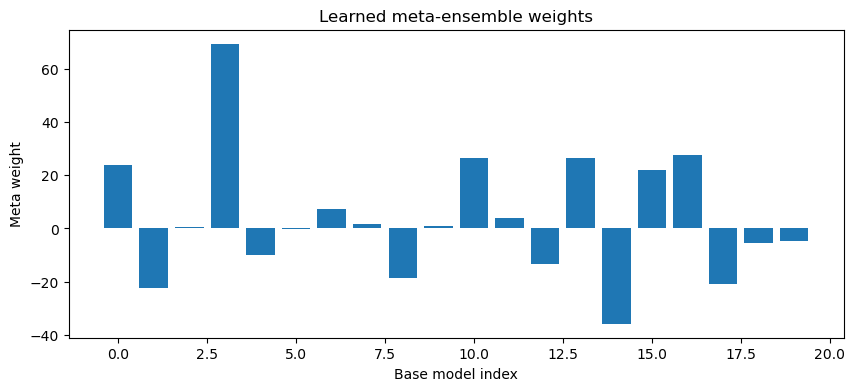

In [42]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.bar(np.arange(len(weights_mean)), weights_mean)
plt.xlabel("Base model index")
plt.ylabel("Meta weight")
plt.title("Learned meta-ensemble weights")
plt.show()


In [44]:
def CV_ens(task, params):
    y_val = np.load("all_data.npy")[:,0]
    y_mask = np.isnan(y_val)
    y_mask = ~y_mask
    y_val = np.load("all_data.npy")[:,0][y_mask]
    
    val_preds = np.stack(val_preds_dict[0])   # shape: (num_models_total, N_val)
    test_preds = np.stack(test_preds_dict[0]) # shape: (num_models_total, N_test)
    
    # Load ground truth for validation data
      # adjust if needed
    
    # Transpose so shape = (N_val, num_models_total)
    X_val = val_preds.T[y_mask]
    X_test = test_preds.T
    
    # --- Meta cross-validation ---
    kf = KFold(n_splits=meta_folds, shuffle=True, random_state=42)
    meta_oof = np.zeros(len(y_val))
    weights_all = []
    
    for train_idx, valid_idx in kf.split(X_val):
        X_tr, X_va = X_val[train_idx], X_val[valid_idx]
        y_tr, y_va = y_val[train_idx], y_val[valid_idx]
    
        model = make_pipeline(StandardScaler(), Ridge(**params))
        model.fit(X_tr, y_tr)
        aaa = model.predict(X_va)
        
        meta_oof[valid_idx] = model.predict(X_va)
    
        weights_all.append(model.named_steps["ridge"].coef_)
    
    # Evaluate CV performance
    r2 = r2_score(y_val, meta_oof)
    rmse = mean_squared_error(y_val, meta_oof)
    print(f"Meta-model CV R²: {r2:.4f}, RMSE: {rmse:.4f}")
    return rmse
    


In [46]:
import numpy as np
import optuna
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import optuna.visualization as vis

# Config
num_folds = 5
num_models = 5
num_tasks = 5
meta_folds = 5  # how many folds for the meta-ensemble training

# Load predictions
val_preds_dict, test_preds_dict = defaultdict(list), defaultdict(list)

for fold in range(num_folds):
    for model_ in range(2, num_models + 1):
        for task in range(num_tasks):
            val_preds_dict[task].append(np.load(f'preds_val_{fold}_model{model_}_{task}.npy'))
            test_preds_dict[task].append(np.load(f'preds_test_{fold}_model{model_}_{task}.npy'))


# -------------------------
# Original CV function
# -------------------------
def CV_ens(task, params):
    y_val = np.load("all_data.npy")[:, 0]
    y_mask = ~np.isnan(y_val)
    y_val = y_val[y_mask]

    val_preds = np.stack(val_preds_dict[0])   # (num_models_total, N_val)
    test_preds = np.stack(test_preds_dict[0]) # (num_models_total, N_test)

    X_val = val_preds.T[y_mask]
    X_test = test_preds.T

    kf = KFold(n_splits=meta_folds, shuffle=True, random_state=42)
    meta_oof = np.zeros(len(y_val))
    weights_all = []

    for train_idx, valid_idx in kf.split(X_val):
        X_tr, X_va = X_val[train_idx], X_val[valid_idx]
        y_tr, y_va = y_val[train_idx], y_val[valid_idx]

        model = make_pipeline(StandardScaler(), Ridge(**params))
        model.fit(X_tr, y_tr)
        preds = model.predict(X_va)

        meta_oof[valid_idx] = preds
        weights_all.append(model.named_steps["ridge"].coef_)

    r2 = r2_score(y_val, meta_oof)
    rmse = mean_squared_error(y_val, meta_oof)
    print(f"Meta-model CV R²: {r2:.4f}, RMSE: {rmse:.4f}")
    return rmse

# -------------------------
# Optuna Objective Function
# -------------------------
def objective(trial):
    params = {
        "alpha": trial.suggest_float("alpha", 1e-3, 100.0, log=True),
        "fit_intercept": trial.suggest_categorical("fit_intercept", [True, False]),
        "solver": trial.suggest_categorical("solver", ["auto", "svd", "cholesky", "lsqr", "sparse_cg", "sag", "saga"])
    }
    rmse = CV_ens(task="ridge_meta", params=params)
    return rmse  # Optuna minimizes by default

# -------------------------
# Run Optuna Study
# -------------------------
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50, n_jobs=1, show_progress_bar=True)

# -------------------------
# Print and Save Results
# -------------------------
print("\nBest RMSE:", study.best_value)
print("Best Params:", study.best_params)

# -------------------------
# Plot Optimization History
# -------------------------
# fig1 = vis.plot_optimization_history(study)
# fig1.show()

# fig2 = vis.plot_param_importances(study)
# fig2.show()

# -------------------------
# Fit Final Model on All Data
# -------------------------
best_params = study.best_params
y_val = np.load("all_data.npy")[:, 0]
y_mask = ~np.isnan(y_val)
y_val = y_val[y_mask]

val_preds = np.stack(val_preds_dict[0])
test_preds = np.stack(test_preds_dict[0])

X_val = val_preds.T[y_mask]
X_test = test_preds.T

final_model = make_pipeline(StandardScaler(), Ridge(**best_params))
final_model.fit(X_val, y_val)

print("✅ Final model trained with best parameters.")


[I 2025-12-01 10:15:30,594] A new study created in memory with name: no-name-6bbdbe29-5efd-458c-b0ae-f8448ae35fca


  0%|          | 0/50 [00:00<?, ?it/s]

Meta-model CV R²: 0.2700, RMSE: 10922.8326
[I 2025-12-01 10:15:30,672] Trial 0 finished with value: 10922.83258449037 and parameters: {'alpha': 24.57917109139049, 'fit_intercept': True, 'solver': 'cholesky'}. Best is trial 0 with value: 10922.83258449037.
Meta-model CV R²: -3.6848, RMSE: 70095.4482
[I 2025-12-01 10:15:30,693] Trial 1 finished with value: 70095.44823605724 and parameters: {'alpha': 0.005579864210547301, 'fit_intercept': False, 'solver': 'svd'}. Best is trial 0 with value: 10922.83258449037.
Meta-model CV R²: -3.6847, RMSE: 70094.0084
[I 2025-12-01 10:15:30,715] Trial 2 finished with value: 70094.0084475963 and parameters: {'alpha': 0.013743270647179746, 'fit_intercept': False, 'solver': 'cholesky'}. Best is trial 0 with value: 10922.83258449037.
Meta-model CV R²: -3.6846, RMSE: 70092.2373
[I 2025-12-01 10:15:30,829] Trial 3 finished with value: 70092.23731805888 and parameters: {'alpha': 0.032606912159918115, 'fit_intercept': False, 'solver': 'saga'}. Best is trial 0 wi

In [71]:
import numpy as np
import optuna
from sklearn.linear_model import Ridge, ElasticNet
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import KFold
from collections import defaultdict

# Config
num_folds = 5
num_models = 5
num_tasks = 5
meta_folds = 5

# Load predictions
val_preds_dict, test_preds_dict = defaultdict(list), defaultdict(list)

for fold in range(num_folds):
    for model_ in range(2, num_models + 1):
        for task in range(num_tasks):
            val_preds_dict[task].append(np.load(f'preds_val_{task}_model{model_}_{fold}.npy'))
            test_preds_dict[task].append(np.load(f'preds_test_{task}_model{model_}_{fold}.npy'))

# -------------------------
# CV Function (task-aware)
# -------------------------
def CV_ens(task, params):
    y_val = np.load("all_data.npy")[:, task]
    y_mask = ~np.isnan(y_val)
    y_val = y_val[y_mask]

    val_preds = np.stack(val_preds_dict[task])
    test_preds = np.stack(test_preds_dict[task])

    X_val = val_preds.T[y_mask]
    X_test = test_preds.T

    kf = KFold(n_splits=meta_folds, shuffle=True, random_state=42)
    meta_oof = np.zeros(len(y_val))
    weights_all = []

    for train_idx, valid_idx in kf.split(X_val):
        X_tr, X_va = X_val[train_idx], X_val[valid_idx]
        y_tr, y_va = y_val[train_idx], y_val[valid_idx]

        if params["model_type"] == "ridge":
            model = make_pipeline(StandardScaler(), Ridge(
                alpha=params["alpha"],
                fit_intercept=params["fit_intercept"],
                solver=params["solver"]
            ))
        else:
            model = make_pipeline(StandardScaler(), ElasticNet(
                alpha=params["alpha"],
                l1_ratio=params["l1_ratio"],
                fit_intercept=params["fit_intercept"],
                max_iter=10000
            ))

        model.fit(X_tr, y_tr)
        preds = model.predict(X_va)
        meta_oof[valid_idx] = preds

        if params["model_type"] == "ridge":
            weights_all.append(model.named_steps["ridge"].coef_)
        else:
            weights_all.append(model.named_steps["elasticnet"].coef_)

    r2 = r2_score(y_val, meta_oof)
    rmse = mean_squared_error(y_val, meta_oof)
    print(f"[Task {task}] Meta-model CV R²: {r2:.4f}, RMSE: {rmse:.4f}")
    return rmse

# -------------------------
# Objective function per task
# -------------------------
# def objective_task(trial, task):
#     model_type = trial.suggest_categorical("model_type", ["ridge", "elasticnet"])
#     alpha = trial.suggest_float("alpha", 1e-3, 100.0, log=True)
#     fit_intercept = trial.suggest_categorical("fit_intercept", [True, False])

#     if model_type == "ridge":
#         solver = trial.suggest_categorical("solver", ["auto", "svd", "cholesky", "lsqr", "sparse_cg", "sag", "saga"])
#         params = {"model_type": model_type, "alpha": alpha, "fit_intercept": fit_intercept, "solver": solver}
#     else:
#         l1_ratio = trial.suggest_float("l1_ratio", 0.0, 1.0)
#         params = {"model_type": model_type, "alpha": alpha, "fit_intercept": fit_intercept, "l1_ratio": l1_ratio}

#     rmse = CV_ens(task=task, params=params)
#     return rmse

# def objective(trial):
#     model_type = trial.suggest_categorical("model_type", ["ridge", "elasticnet"])
#     alpha = trial.suggest_float("alpha", 1e-4, 100.0, log=True)
#     fit_intercept = trial.suggest_categorical("fit_intercept", [True, False])
#     use_scaler = trial.suggest_categorical("use_scaler", [True, False])

#     if model_type == "ridge":
#         solver = trial.suggest_categorical("solver", ["auto", "cholesky", "saga"])
#         params = {
#             "model_type": model_type,
#             "alpha": alpha,
#             "fit_intercept": fit_intercept,
#             "solver": solver,
#             "use_scaler": use_scaler
#         }
#     else:
#         l1_ratio = trial.suggest_float("l1_ratio", 0.0, 1.0)
#         warm_start = trial.suggest_categorical("warm_start", [True, False])
#         params = {
#             "model_type": model_type,
#             "alpha": alpha,
#             "fit_intercept": fit_intercept,
#             "l1_ratio": l1_ratio,
#             "warm_start": warm_start,
#             "use_scaler": use_scaler
#         }

#     rmse = CV_ens(task="meta", params=params)

#     # Optional: stability penalty on coefficient magnitudes
#     # (if CV_ens stores global weights)
#     global weights_all
#     if "weights_all" in globals() and len(weights_all) > 0:
#         avg_norm = np.mean([np.linalg.norm(w) for w in weights_all])
#         rmse += 0.001 * avg_norm

#     return rmse

from sklearn.linear_model import Ridge, ElasticNet
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np


# -------------------------
# Utility: decorrelate base predictions with PCA
# -------------------------
def decorrelate_preds(X, keep=0.95):
    """Reduce correlation among base model predictions for more stable meta weights."""
    pca = PCA(n_components=keep, svd_solver='full')
    X_new = pca.fit_transform(X)
    return X_new, pca


# -------------------------
# Cross-validation function (robust meta training)
# -------------------------
def CV_ens(task, params, n_meta_folds=5, random_state=42):
    """
    Cross-validation meta-training for one task.
    Includes:
        - PCA decorrelation
        - coefficient norm penalty
        - stability diagnostics
    """
    y_val = np.load("all_data.npy")[:, task]
    y_mask = ~np.isnan(y_val)
    y_val = y_val[y_mask]

    val_preds = np.stack(val_preds_dict[task])  # (num_base_models, num_samples)
    test_preds = np.stack(test_preds_dict[task])
    X_val = val_preds.T[y_mask]
    X_test = test_preds.T

    # Scale + decorrelate
    scaler = StandardScaler()
    X_val = scaler.fit_transform(X_val)
    X_val, pca = decorrelate_preds(X_val, keep=0.95)

    # CV setup
    kf = KFold(n_splits=n_meta_folds, shuffle=True, random_state=random_state)
    meta_oof = np.zeros(len(y_val))
    weights_all = []
    r2s, rmses = [], []

    for train_idx, valid_idx in kf.split(X_val):
        X_tr, X_va = X_val[train_idx], X_val[valid_idx]
        y_tr, y_va = y_val[train_idx], y_val[valid_idx]

        # Robust meta-model definition
        if params["model_type"] == "ridge":
            model = Ridge(
                alpha=params["alpha"],
                fit_intercept=params["fit_intercept"],
                solver=params["solver"],
                random_state=random_state
            )
        else:
            model = ElasticNet(
                alpha=params["alpha"],
                l1_ratio=params["l1_ratio"],
                fit_intercept=params["fit_intercept"],
                max_iter=10000,
                random_state=random_state
            )

        # Multi-seed meta-stabilization (average of small variations)
        preds_seed_avg = np.zeros(len(valid_idx))
        for seed in [0, 21, 42]:
            model.random_state = seed
            model.fit(X_tr, y_tr)
            preds_seed_avg += model.predict(X_va) / 3
        preds = preds_seed_avg

        meta_oof[valid_idx] = preds
        weights_all.append(model.coef_)

        # Metrics
        r2s.append(r2_score(y_va, preds))
        rmses.append(mean_squared_error(y_va, preds))

    # Evaluate
    r2 = np.mean(r2s)
    rmse = np.mean(rmses)

    # Coefficient stability index (lower = more stable)
    weights_all = np.stack(weights_all)
    coef_std = np.std(weights_all, axis=0).mean()

    # Add smooth regularization penalty
    loss = rmse + 0.001 * np.mean(np.linalg.norm(weights_all, axis=1))

    print(f"[Task {task}] R²={r2:.4f}, RMSE={rmse:.4f}, Stability={coef_std:.4f}")

    return loss  # Optuna minimizes this



def objective_task(trial, task):
    model_type = trial.suggest_categorical("model_type", ["ridge", "elasticnet"])
    alpha = trial.suggest_float("alpha", 1e-2, 1e3, log=True)
    fit_intercept = trial.suggest_categorical("fit_intercept", [True, False])

    if model_type == "ridge":
        solver = trial.suggest_categorical("solver", ["auto", "cholesky", "lsqr", "sag"])
        params = {
            "model_type": model_type,
            "alpha": alpha,
            "fit_intercept": fit_intercept,
            "solver": solver,
        }
    else:
        # Bias toward smooth ElasticNet (mostly Ridge-like)
        l1_ratio = trial.suggest_float("l1_ratio", 0.05, 0.5)
        params = {
            "model_type": model_type,
            "alpha": alpha,
            "fit_intercept": fit_intercept,
            "l1_ratio": l1_ratio,
        }

    # Run robust meta CV
    loss = CV_ens(task=task, params=params)

    # Small penalty for too-small alpha (to avoid overfitting)
    if alpha < 0.1:
        loss += 0.05

    return loss


# -------------------------
# Optimize and Train Final Models for All Tasks
# -------------------------
task_best_params = {}
task_test_preds = []
task_val_preds = []
intercepts = {}

for task in range(num_tasks):
    print(f"\n🎯 Optimizing Task {task}")
    study = optuna.create_study(
    direction="minimize",
    sampler=optuna.samplers.TPESampler(multivariate=True, n_startup_trials=10, seed=42),
    pruner=optuna.pruners.MedianPruner(n_startup_trials=10, n_warmup_steps=5)
)
    study.optimize(lambda trial: objective_task(trial, task), n_trials=150, show_progress_bar=True)

    best_params = study.best_params
    task_best_params[task] = best_params
    print(f"✅ Task {task} Best RMSE: {study.best_value}")
    print(f"🏆 Task {task} Best Params: {best_params}")

    # Train final meta-model on all validation data
    y_val = np.load("all_data.npy")[:, task]
    y_mask = ~np.isnan(y_val)
    y_val = y_val[y_mask]

    val_preds = np.stack(val_preds_dict[task])
    test_preds = np.stack(test_preds_dict[task])

    X_val = val_preds.T[y_mask]
    X_test = test_preds.T

    if best_params["model_type"] == "ridge":
        final_model = make_pipeline(StandardScaler(), Ridge(
            alpha=best_params["alpha"],
            fit_intercept=best_params["fit_intercept"],
            solver=best_params["solver"]
        ))
    else:
        final_model = make_pipeline(StandardScaler(), ElasticNet(
            alpha=best_params["alpha"],
            l1_ratio=best_params["l1_ratio"],
            fit_intercept=best_params["fit_intercept"],
            max_iter=10000
        ))

    final_model.fit(X_val, y_val)
    X_val = np.stack(val_preds_dict[task])
    X_val = X_val.T
    # Predict on test set
    task_test_preds.append(final_model.predict(X_test))
    task_val_preds.append(final_model.predict(X_val))
    
    # ---- extract final regressor ----
    base_model = list(final_model.named_steps.values())[-1]
    coef = base_model.coef_
    intercept = float(base_model.intercept_)
    intercepts[task] = intercept

    # ---- save metadata ----
    saved_models[task] = {
        "best_params": best_params,
        "coef_": coef,
        "intercept_": intercept
    }
    # ---- optional: save trained pipeline directly ----
    joblib.dump(final_model, f"final_meta_model_task_{task}.pkl")

# ✅ Save all learned model metadata together
joblib.dump(saved_models, "all_meta_models.pkl")
print("💾 Saved all meta-models (params, coef, intercept) to all_meta_models.pkl")
# -------------------------
# Save final test predictions for all tasks
# -------------------------
all_test_preds = np.stack(task_test_preds, axis=1)  # shape: (num_test_samples, num_tasks)
np.save("meta_ensemble_test_preds_all_tasks.npy", all_test_preds)
print(f"\n✅ Final test predictions saved. Shape: {all_test_preds.shape}")

all_val_preds = np.stack(task_val_preds, axis=1)  # shape: (num_test_samples, num_tasks)
np.save("meta_ensemble_val_preds_all_tasks.npy", all_val_preds)
print(f"\n✅ Final test predictions saved. Shape: {all_val_preds.shape}")

# # Optional CSV
# import pandas as pd
# submission = pd.DataFrame(all_val_preds, columns=[f"task_{i}" for i in range(num_tasks)])
# submission.to_csv("meta_ensemble_submission.csv", index=False)
# print("💾 Submission CSV saved: meta_ensemble_submission.csv")


/opt/conda/lib/python3.11/site-packages/optuna/_experimental.py:32: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-12-01 10:24:30,237] A new study created in memory with name: no-name-46f8bdf9-ea2c-46e8-a926-7e1a7b13cece



🎯 Optimizing Task 0


  0%|          | 0/150 [00:00<?, ?it/s]

[Task 0] R²=0.2067, RMSE=11813.1480, Stability=0.0817
[I 2025-12-01 10:24:30,307] Trial 0 finished with value: 11813.153764904144 and parameters: {'model_type': 'elasticnet', 'alpha': 45.70563099801453, 'fit_intercept': True, 'l1_ratio': 0.1201975341512912}. Best is trial 0 with value: 11813.153764904144.
[Task 0] R²=0.4960, RMSE=7464.0229, Stability=0.3490
[I 2025-12-01 10:24:30,344] Trial 1 finished with value: 7464.041880049832 and parameters: {'model_type': 'elasticnet', 'alpha': 10.129197956845726, 'fit_intercept': True, 'l1_ratio': 0.48645943347289744}. Best is trial 1 with value: 7464.041880049832.
[Task 0] R²=-3.6545, RMSE=66627.7751, Stability=8.4440
[I 2025-12-01 10:24:30,382] Trial 2 finished with value: 66627.88769338792 and parameters: {'model_type': 'ridge', 'alpha': 0.08111941985431921, 'fit_intercept': False, 'solver': 'sag'}. Best is trial 1 with value: 7464.041880049832.
[Task 0] R²=-3.5504, RMSE=65270.9296, Stability=4.5175
[I 2025-12-01 10:24:30,408] Trial 3 finishe

/opt/conda/lib/python3.11/site-packages/optuna/_experimental.py:32: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-12-01 10:24:33,294] A new study created in memory with name: no-name-2658b095-712f-44c4-90ec-feac8da7671b


[Task 0] R²=0.6936, RMSE=4444.5350, Stability=2.2019
[I 2025-12-01 10:24:33,247] Trial 147 finished with value: 4444.590008248099 and parameters: {'model_type': 'ridge', 'alpha': 18.73576101314138, 'fit_intercept': True, 'solver': 'auto'}. Best is trial 73 with value: 4443.229403782548.
[W 2025-12-01 10:24:33,249] The parameter `solver` in Trial#148 is sampled independently using `RandomSampler` instead of `TPESampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported for `multivariate=True`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler` if this independent sampling is intended behavior.
[Task 0] R²=0.6936, RMSE=4443.1794, Stability=2.2789
[I 2025-12-01 10:24:33,265] Trial 148 finished with value: 4443.235381027792 and parameters: {'model_type': 'ridge', 'alpha': 13.546894285436885, 'fit_intercept': True, 'solver': 'cholesky'}. Best is trial 73 wit

  0%|          | 0/150 [00:00<?, ?it/s]

[Task 1] R²=-0.0241, RMSE=9.0660, Stability=0.0000
[I 2025-12-01 10:24:33,316] Trial 0 finished with value: 9.066035120709515 and parameters: {'model_type': 'elasticnet', 'alpha': 45.70563099801453, 'fit_intercept': True, 'l1_ratio': 0.1201975341512912}. Best is trial 0 with value: 9.066035120709515.
[Task 1] R²=-0.0241, RMSE=9.0660, Stability=0.0000
[I 2025-12-01 10:24:33,333] Trial 1 finished with value: 9.066035120709515 and parameters: {'model_type': 'elasticnet', 'alpha': 10.129197956845726, 'fit_intercept': True, 'l1_ratio': 0.48645943347289744}. Best is trial 0 with value: 9.066035120709515.
[Task 1] R²=-947.0077, RMSE=7921.4837, Stability=3.5452
[I 2025-12-01 10:24:33,358] Trial 2 finished with value: 7921.5463262065 and parameters: {'model_type': 'ridge', 'alpha': 0.08111941985431921, 'fit_intercept': False, 'solver': 'sag'}. Best is trial 0 with value: 9.066035120709515.
[Task 1] R²=-884.7359, RMSE=7403.5805, Stability=1.8232
[I 2025-12-01 10:24:33,375] Trial 3 finished with 

/opt/conda/lib/python3.11/site-packages/optuna/_experimental.py:32: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-12-01 10:24:36,364] A new study created in memory with name: no-name-ea875034-a0c2-4dbb-9831-8eb50146bf0b



🎯 Optimizing Task 2


  0%|          | 0/150 [00:00<?, ?it/s]

[Task 2] R²=0.3445, RMSE=47.1136, Stability=0.0035
[I 2025-12-01 10:24:36,386] Trial 0 finished with value: 47.114110354198246 and parameters: {'model_type': 'elasticnet', 'alpha': 45.70563099801453, 'fit_intercept': True, 'l1_ratio': 0.1201975341512912}. Best is trial 0 with value: 47.114110354198246.
[Task 2] R²=0.7264, RMSE=19.6377, Stability=0.0050
[I 2025-12-01 10:24:36,402] Trial 1 finished with value: 19.638909302428367 and parameters: {'model_type': 'elasticnet', 'alpha': 10.129197956845726, 'fit_intercept': True, 'l1_ratio': 0.48645943347289744}. Best is trial 1 with value: 19.638909302428367.
[Task 2] R²=0.1528, RMSE=60.1949, Stability=0.4757
[I 2025-12-01 10:24:36,424] Trial 2 finished with value: 60.24816177998223 and parameters: {'model_type': 'ridge', 'alpha': 0.08111941985431921, 'fit_intercept': False, 'solver': 'sag'}. Best is trial 1 with value: 19.638909302428367.
[Task 2] R²=0.1851, RMSE=57.5118, Stability=0.1997
[I 2025-12-01 10:24:36,441] Trial 3 finished with val

/opt/conda/lib/python3.11/site-packages/optuna/_experimental.py:32: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-12-01 10:24:39,666] A new study created in memory with name: no-name-17155f18-3d28-48cb-a14f-7749e3216a58


[Task 2] R²=0.8487, RMSE=10.9672, Stability=0.1720
[I 2025-12-01 10:24:39,492] Trial 141 finished with value: 10.969569593812107 and parameters: {'model_type': 'elasticnet', 'alpha': 0.36746295661747197, 'fit_intercept': True, 'l1_ratio': 0.3092237041719163}. Best is trial 10 with value: 10.911139887725223.
[W 2025-12-01 10:24:39,495] The parameter `l1_ratio` in Trial#142 is sampled independently using `RandomSampler` instead of `TPESampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported for `multivariate=True`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler` if this independent sampling is intended behavior.
[Task 2] R²=0.8499, RMSE=10.9133, Stability=0.1795
[I 2025-12-01 10:24:39,513] Trial 142 finished with value: 10.915673922802656 and parameters: {'model_type': 'elasticnet', 'alpha': 0.31248852278876826, 'fit_intercept': True, 'l1_ratio': 0.2

  0%|          | 0/150 [00:00<?, ?it/s]

[Task 3] R²=-0.0147, RMSE=0.0624, Stability=0.0000
[I 2025-12-01 10:24:39,687] Trial 0 finished with value: 0.0624277647792439 and parameters: {'model_type': 'elasticnet', 'alpha': 45.70563099801453, 'fit_intercept': True, 'l1_ratio': 0.1201975341512912}. Best is trial 0 with value: 0.0624277647792439.
[Task 3] R²=-0.0147, RMSE=0.0624, Stability=0.0000
[I 2025-12-01 10:24:39,705] Trial 1 finished with value: 0.0624277647792439 and parameters: {'model_type': 'elasticnet', 'alpha': 10.129197956845726, 'fit_intercept': True, 'l1_ratio': 0.48645943347289744}. Best is trial 0 with value: 0.0624277647792439.
[Task 3] R²=-0.0613, RMSE=0.0620, Stability=0.0114
[I 2025-12-01 10:24:39,725] Trial 2 finished with value: 0.11210448429121973 and parameters: {'model_type': 'ridge', 'alpha': 0.08111941985431921, 'fit_intercept': False, 'solver': 'sag'}. Best is trial 0 with value: 0.0624277647792439.
[Task 3] R²=-0.0527, RMSE=0.0622, Stability=0.0004
[I 2025-12-01 10:24:39,741] Trial 3 finished with v

/opt/conda/lib/python3.11/site-packages/optuna/_experimental.py:32: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-12-01 10:24:42,475] A new study created in memory with name: no-name-36290bbd-f277-4304-8b26-f02f6005d8c4


[Task 3] R²=0.8314, RMSE=0.0098, Stability=0.0036
[I 2025-12-01 10:24:42,410] Trial 146 finished with value: 0.009889184603014712 and parameters: {'model_type': 'ridge', 'alpha': 7.883098247545583, 'fit_intercept': True, 'solver': 'cholesky'}. Best is trial 132 with value: 0.00988761686977217.
[W 2025-12-01 10:24:42,413] The parameter `solver` in Trial#147 is sampled independently using `RandomSampler` instead of `TPESampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported for `multivariate=True`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler` if this independent sampling is intended behavior.
[Task 3] R²=0.8293, RMSE=0.0099, Stability=0.0030
[I 2025-12-01 10:24:42,428] Trial 147 finished with value: 0.009962319964386488 and parameters: {'model_type': 'ridge', 'alpha': 32.12319775899022, 'fit_intercept': True, 'solver': 'cholesky'}. Best is trial 

  0%|          | 0/150 [00:00<?, ?it/s]

[Task 4] R²=-0.0579, RMSE=0.1157, Stability=0.0000
[I 2025-12-01 10:24:42,496] Trial 0 finished with value: 0.11571784761593966 and parameters: {'model_type': 'elasticnet', 'alpha': 45.70563099801453, 'fit_intercept': True, 'l1_ratio': 0.1201975341512912}. Best is trial 0 with value: 0.11571784761593966.
[Task 4] R²=-0.0579, RMSE=0.1157, Stability=0.0000
[I 2025-12-01 10:24:42,514] Trial 1 finished with value: 0.11571784761593966 and parameters: {'model_type': 'elasticnet', 'alpha': 10.129197956845726, 'fit_intercept': True, 'l1_ratio': 0.48645943347289744}. Best is trial 0 with value: 0.11571784761593966.
[Task 4] R²=-90.5656, RMSE=9.6310, Stability=0.1703
[I 2025-12-01 10:24:42,539] Trial 2 finished with value: 9.681425916113474 and parameters: {'model_type': 'ridge', 'alpha': 0.08111941985431921, 'fit_intercept': False, 'solver': 'sag'}. Best is trial 0 with value: 0.11571784761593966.
[Task 4] R²=-81.3136, RMSE=8.3159, Stability=0.0233
[I 2025-12-01 10:24:42,555] Trial 3 finished w

In [72]:
saved_models = joblib.load("all_meta_models.pkl")

In [73]:
saved_models

{0: {'best_params': {'model_type': 'ridge',
   'alpha': 13.84549075920271,
   'fit_intercept': True,
   'solver': 'cholesky'},
  'coef_': array([-16.72127241,  -2.49188248,   8.53913106,   9.43110411,
         -20.30862027,  10.91753997,  -6.17153741,  38.65784852,
           0.90702091,   4.9061801 ,  -7.50829528,  17.61095137,
         -17.86390368,   2.44815057,   4.06831426,   0.69719664,
          11.91801253,  45.94486843,  16.94822247,  10.28165199]),
  'intercept_': 241.32738589211618},
 1: {'best_params': {'model_type': 'ridge',
   'alpha': 72.20616200766035,
   'fit_intercept': True,
   'solver': 'lsqr'},
  'coef_': array([ 0.13253634, -0.04475433,  0.01180368, -0.01237364, -0.01965473,
         -0.06265438, -0.05638976,  0.34670816, -0.06958184,  0.03947368,
          0.03161891,  0.7092585 ,  0.01362343, -0.17976936, -0.1093882 ,
          0.01480642, -0.11367856, -0.17895494, -0.1669423 ,  0.24196623]),
  'intercept_': 82.29379807692307},
 2: {'best_params': {'model_type':

In [74]:
task_best_params

{0: {'model_type': 'ridge',
  'alpha': 13.84549075920271,
  'fit_intercept': True,
  'solver': 'cholesky'},
 1: {'model_type': 'ridge',
  'alpha': 72.20616200766035,
  'fit_intercept': True,
  'solver': 'lsqr'},
 2: {'model_type': 'elasticnet',
  'alpha': 0.27951761486591015,
  'fit_intercept': True,
  'l1_ratio': 0.27381153834755384},
 3: {'model_type': 'ridge',
  'alpha': 10.470427546164009,
  'fit_intercept': True,
  'solver': 'cholesky'},
 4: {'model_type': 'ridge',
  'alpha': 33.56563731076801,
  'fit_intercept': True,
  'solver': 'lsqr'}}


🔹 Task 0
Base models correlation with true labels: [0.568 0.559 0.529 0.584 0.387 0.749 0.324 0.746 0.525 0.267 0.554 0.693
 0.498 0.635 0.466 0.505 0.777 0.792 0.364 0.704]
Meta-model correlation: 0.872, RMSE: 60.043
Meta-model coefficients: [-16.721  -2.492   8.539   9.431 -20.309  10.918  -6.172  38.658   0.907
   4.906  -7.508  17.611 -17.864   2.448   4.068   0.697  11.918  45.945
  16.948  10.282]


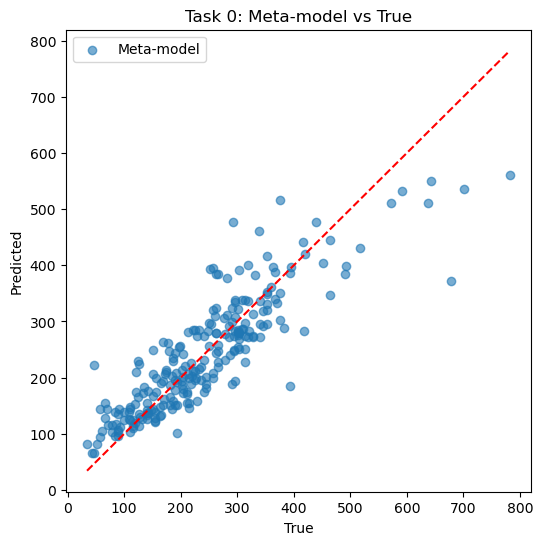

<Figure size 640x480 with 0 Axes>

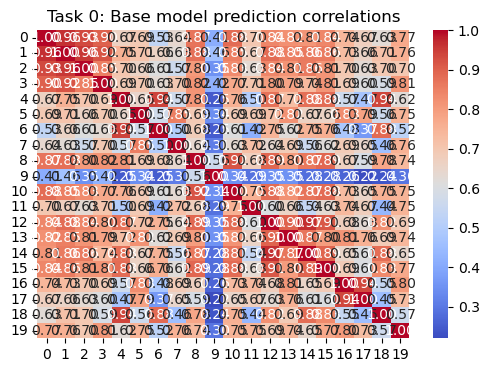


🔹 Task 1
Base models correlation with true labels: [-0.093 -0.149 -0.016  0.105  0.121 -0.057 -0.01   0.31   0.098  0.103
 -0.074  0.39   0.162  0.014  0.03   0.235  0.041 -0.063 -0.011  0.225]
Meta-model correlation: 0.432, RMSE: 2.720
Meta-model coefficients: [ 0.133 -0.045  0.012 -0.012 -0.02  -0.063 -0.056  0.347 -0.07   0.039
  0.032  0.709  0.014 -0.18  -0.109  0.015 -0.114 -0.179 -0.167  0.242]


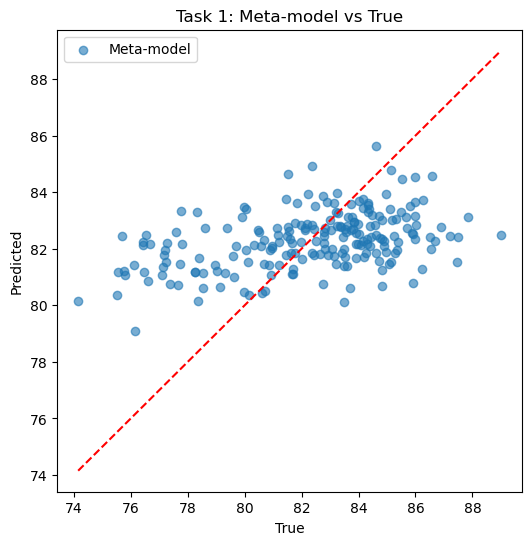

<Figure size 640x480 with 0 Axes>

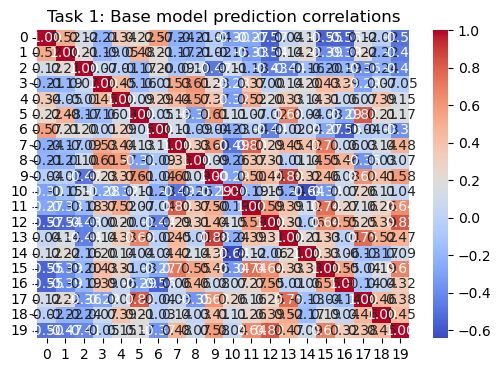


🔹 Task 2
Base models correlation with true labels: [0.821 0.831 0.82  0.756 0.837 0.876 0.876 0.884 0.668 0.796 0.778 0.875
 0.887 0.894 0.911 0.9   0.816 0.826 0.849 0.853]
Meta-model correlation: 0.947, RMSE: 2.751
Meta-model coefficients: [ 0.533  0.549  0.331 -0.    -0.029  0.591  0.262  1.07  -0.798 -0.
  0.169  1.321  0.393  0.257  0.737  1.417  0.053  0.     0.4    0.993]


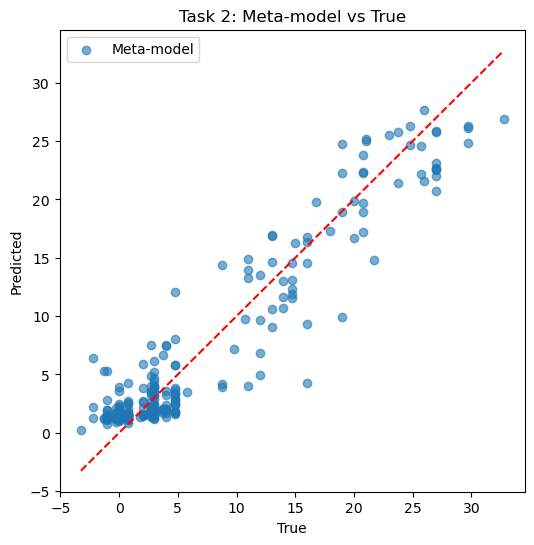

<Figure size 640x480 with 0 Axes>

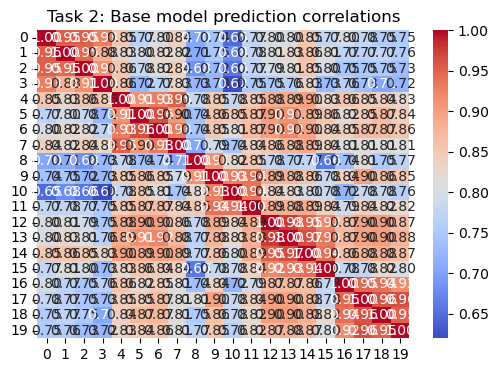


🔹 Task 3
Base models correlation with true labels: [0.823 0.801 0.813 0.89  0.861 0.496 0.838 0.864 0.803 0.822 0.808 0.866
 0.683 0.766 0.656 0.811 0.844 0.865 0.848 0.861]
Meta-model correlation: 0.955, RMSE: 0.074
Meta-model coefficients: [-0.024 -0.003 -0.013  0.112  0.039 -0.003  0.002  0.025 -0.04   0.005
 -0.001  0.082  0.012 -0.014  0.002  0.01  -0.014  0.036  0.007  0.029]


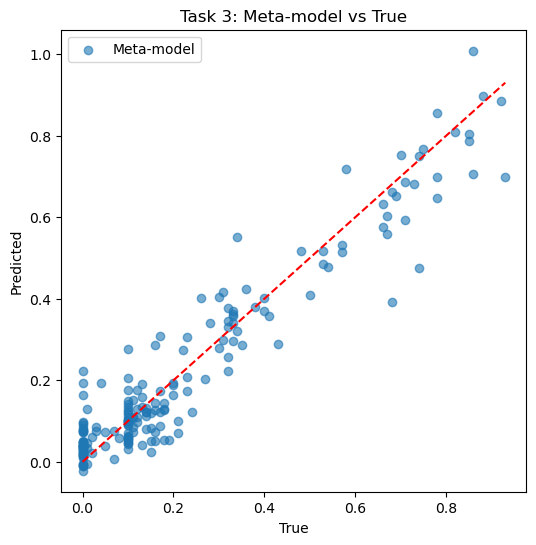

<Figure size 640x480 with 0 Axes>

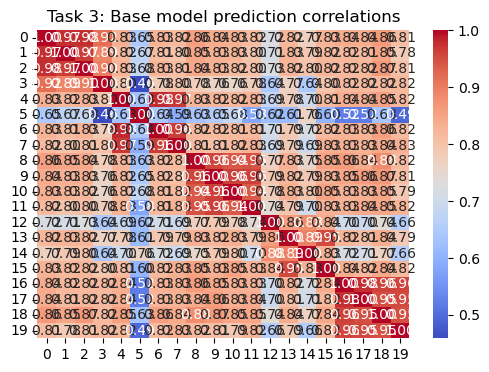


🔹 Task 4
Base models correlation with true labels: [0.768 0.732 0.279 0.777 0.579 0.622 0.302 0.765 0.694 0.338 0.408 0.459
 0.46  0.801 0.317 0.837 0.638 0.698 0.293 0.824]
Meta-model correlation: 0.907, RMSE: 0.143
Meta-model coefficients: [ 0.025 -0.002  0.006  0.033 -0.006 -0.009  0.02   0.09   0.013 -0.014
 -0.014 -0.008  0.007  0.014 -0.     0.083 -0.041  0.001  0.     0.121]


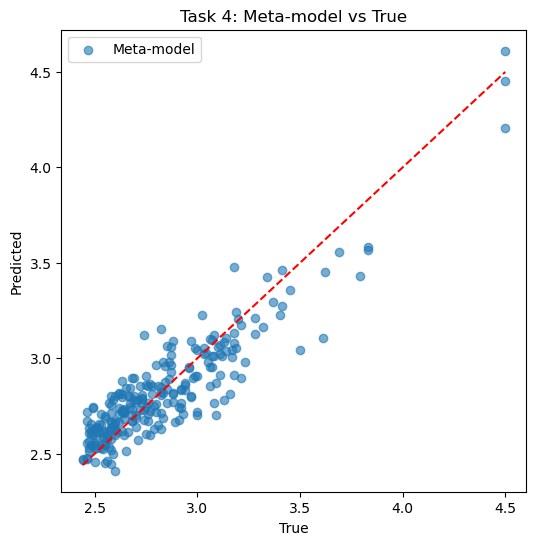

<Figure size 640x480 with 0 Axes>

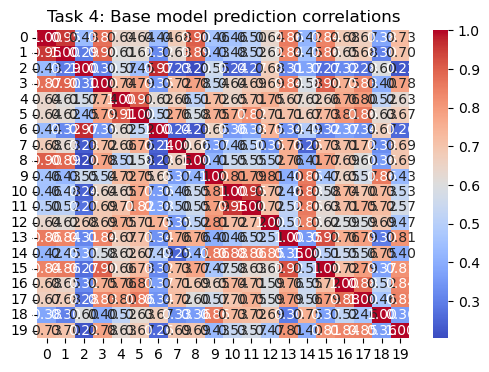

In [75]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

num_tasks = 5

for task in range(num_tasks):
    print(f"\n🔹 Task {task}")

    # Get true labels
    y_val = np.load("all_data.npy")[:, task]
    y_mask = ~np.isnan(y_val)
    y_val = y_val[y_mask]

    # Stack OOF predictions from all base models
    val_preds = np.stack(val_preds_dict[task])   # (num_models_total, N_val)
    X_val = val_preds.T[y_mask]

    # Meta-model trained on full validation set
    best_params = task_best_params[task]
    if best_params["model_type"] == "ridge":
        final_model = make_pipeline(StandardScaler(), Ridge(
            alpha=best_params["alpha"],
            fit_intercept=best_params["fit_intercept"],
            solver=best_params["solver"]
        ))
    else:
        final_model = make_pipeline(StandardScaler(), ElasticNet(
            alpha=best_params["alpha"],
            l1_ratio=best_params["l1_ratio"],
            fit_intercept=best_params["fit_intercept"],
            max_iter=10000
        ))
    final_model.fit(X_val, y_val)

    # Meta-model predictions on validation
    meta_val_preds = final_model.predict(X_val)

    # Base model correlations
    base_corrs = [np.corrcoef(X_val[:, i], y_val)[0, 1] for i in range(X_val.shape[1])]
    print(f"Base models correlation with true labels: {np.round(base_corrs, 3)}")

    # Meta-model correlation
    meta_corr = np.corrcoef(meta_val_preds, y_val)[0, 1]
    meta_rmse = np.sqrt(np.mean((meta_val_preds - y_val)**2))
    print(f"Meta-model correlation: {meta_corr:.3f}, RMSE: {meta_rmse:.3f}")

    # Ridge coefficients
    if best_params["model_type"] == "ridge":
        coefs = final_model.named_steps["ridge"].coef_
    else:
        coefs = final_model.named_steps["elasticnet"].coef_
    print(f"Meta-model coefficients: {np.round(coefs, 3)}")

    # Plot base model vs meta-model predictions
    plt.figure(figsize=(6, 6))
    plt.scatter(y_val, meta_val_preds, alpha=0.6, label='Meta-model')
    plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
    plt.xlabel("True")
    plt.ylabel("Predicted")
    plt.title(f"Task {task}: Meta-model vs True")
    plt.legend()
    plt.show()

    plt.savefig(f'graph_{task}.png', dpi=300, format='png')

    # Heatmap of base model correlations
    plt.figure(figsize=(6, 4))
    sns.heatmap(np.corrcoef(X_val.T), annot=True, fmt=".2f", cmap="coolwarm")
    plt.title(f"Task {task}: Base model prediction correlations")
    plt.show()


In [76]:
X_val[0]

array([2.6767683 , 2.63481688, 2.75439382, 2.49939847, 2.67345047,
       2.69338489, 2.70651531, 2.70666981, 2.68338871, 2.71432447,
       2.61151743, 2.50745678, 2.71602154, 2.69795966, 2.76159167,
       2.80111718, 2.65442371, 2.66919327, 2.75737667, 2.53009343])

In [77]:
import numpy as np
import pandas as pd

num_tasks = 5
summary = []

for task in range(num_tasks):
    # True labels
    y_val = np.load("all_data.npy")[:, task]
    y_mask = ~np.isnan(y_val)
    y_val = y_val[y_mask]

    # Base model predictions
    val_preds = np.stack(val_preds_dict[task])
    X_val = val_preds.T[y_mask]

    # Meta-model
    best_params = task_best_params[task]
    if best_params["model_type"] == "ridge":
        final_model = make_pipeline(StandardScaler(), Ridge(
            alpha=best_params["alpha"],
            fit_intercept=best_params["fit_intercept"],
            solver=best_params["solver"]
        ))
    else:
        final_model = make_pipeline(StandardScaler(), ElasticNet(
            alpha=best_params["alpha"],
            l1_ratio=best_params["l1_ratio"],
            fit_intercept=best_params["fit_intercept"],
            max_iter=10000
        ))
    final_model.fit(X_val, y_val)

    # Meta-model predictions
    meta_val_preds = final_model.predict(X_val)

    # Base model correlations
    base_corrs = [np.corrcoef(X_val[:, i], y_val)[0, 1] for i in range(X_val.shape[1])]
    best_base_corr = np.max(base_corrs)

    # Meta-model stats
    meta_corr = np.corrcoef(meta_val_preds, y_val)[0, 1]
    meta_rmse = np.sqrt(np.mean((meta_val_preds - y_val)**2))

    # Ridge coefficients
    if best_params["model_type"] == "ridge":
        coefs = final_model.named_steps["ridge"].coef_
    else:
        coefs = final_model.named_steps["elasticnet"].coef_
    coef_max, coef_min = np.max(coefs), np.min(coefs)

    # Append to summary
    summary.append({
        "Task": task,
        "Best Base Corr": round(best_base_corr, 3),
        "Meta Corr": round(meta_corr, 3),
        "Meta RMSE": round(meta_rmse, 3),
        "Coef Max": round(coef_max, 3),
        "Coef Min": round(coef_min, 3)
    })

# Create DataFrame
summary_df = pd.DataFrame(summary)
print(summary_df)
summary_df.to_csv("meta_ensemble_summary.csv", index=False)
print("✅ Saved summary table: meta_ensemble_summary.csv")


   Task  Best Base Corr  Meta Corr  Meta RMSE  Coef Max  Coef Min
0     0           0.792      0.872     60.043    45.945   -20.309
1     1           0.390      0.432      2.720     0.709    -0.180
2     2           0.911      0.947      2.751     1.417    -0.798
3     3           0.890      0.955      0.074     0.112    -0.040
4     4           0.837      0.907      0.143     0.121    -0.041
✅ Saved summary table: meta_ensemble_summary.csv


In [78]:
summary_df

,Task,Best Base Corr,Meta Corr,Meta RMSE,Coef Max,Coef Min
0,0,0.792,0.872,60.043,45.945,-20.309
1,1,0.390,0.432,2.720,0.709,-0.180
2,2,0.911,0.947,2.751,1.417,-0.798
3,3,0.890,0.955,0.074,0.112,-0.040
4,4,0.837,0.907,0.143,0.121,-0.041


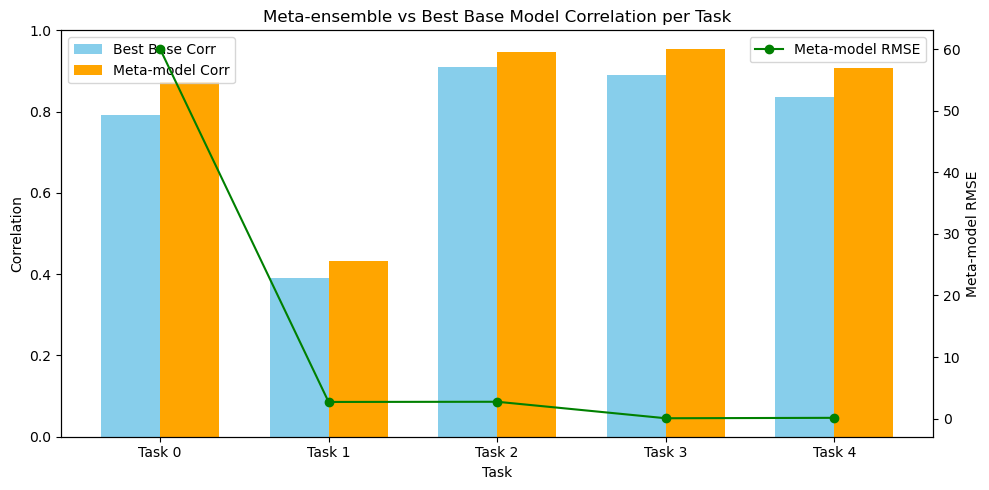

In [79]:
import matplotlib.pyplot as plt
import numpy as np

tasks = summary_df["Task"]
best_base_corr = summary_df["Best Base Corr"]
meta_corr = summary_df["Meta Corr"]
meta_rmse = summary_df["Meta RMSE"]

x = np.arange(len(tasks))
width = 0.35

fig, ax1 = plt.subplots(figsize=(10, 5))

# Correlation bars
bars1 = ax1.bar(x - width/2, best_base_corr, width, label='Best Base Corr', color='skyblue')
bars2 = ax1.bar(x + width/2, meta_corr, width, label='Meta-model Corr', color='orange')

ax1.set_xlabel("Task")
ax1.set_ylabel("Correlation")
ax1.set_xticks(x)
ax1.set_xticklabels([f"Task {t}" for t in tasks])
ax1.set_ylim(0, 1)
ax1.legend(loc='upper left')
ax1.set_title("Meta-ensemble vs Best Base Model Correlation per Task")

# RMSE line (secondary y-axis)
ax2 = ax1.twinx()
ax2.plot(x, meta_rmse, color='green', marker='o', label='Meta-model RMSE')
ax2.set_ylabel("Meta-model RMSE")
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()
